In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms, datasets
from tqdm import tqdm
import numpy as np
from torch.amp import GradScaler, autocast
import timm
from timm.data import Mixup
from sklearn.metrics import roc_auc_score, recall_score, accuracy_score
from PIL import Image
from timm.models.convnext import ConvNeXtBlock
import torch.nn.functional as F
import pandas as pd
from sklearn.model_selection import train_test_split

self-supervied trainging

In [ ]:
class Config:
    data_dir = '../../../../datasets/data.csv'  
    img_size = 224
    patch_size = 16
    mask_ratio = 0.75
    batch_size = 16
    gradient_accum = 4
    weight_decay = 0.05
    device = "cuda" if torch.cuda.is_available() else "cpu"
    num_epochs = 100
    learning_rate = 1e-4
    weight_decay = 1e-4
    patience = 40
    save_dir = 'checkpoints/data_augmentation'
    resume_training = False
    augment_ratio = 4

Original datasize: 605 pairs
train_dataset_original: 484 pairs
val_dataset_original: 121 pairs
train_dataset: 2420 pairs


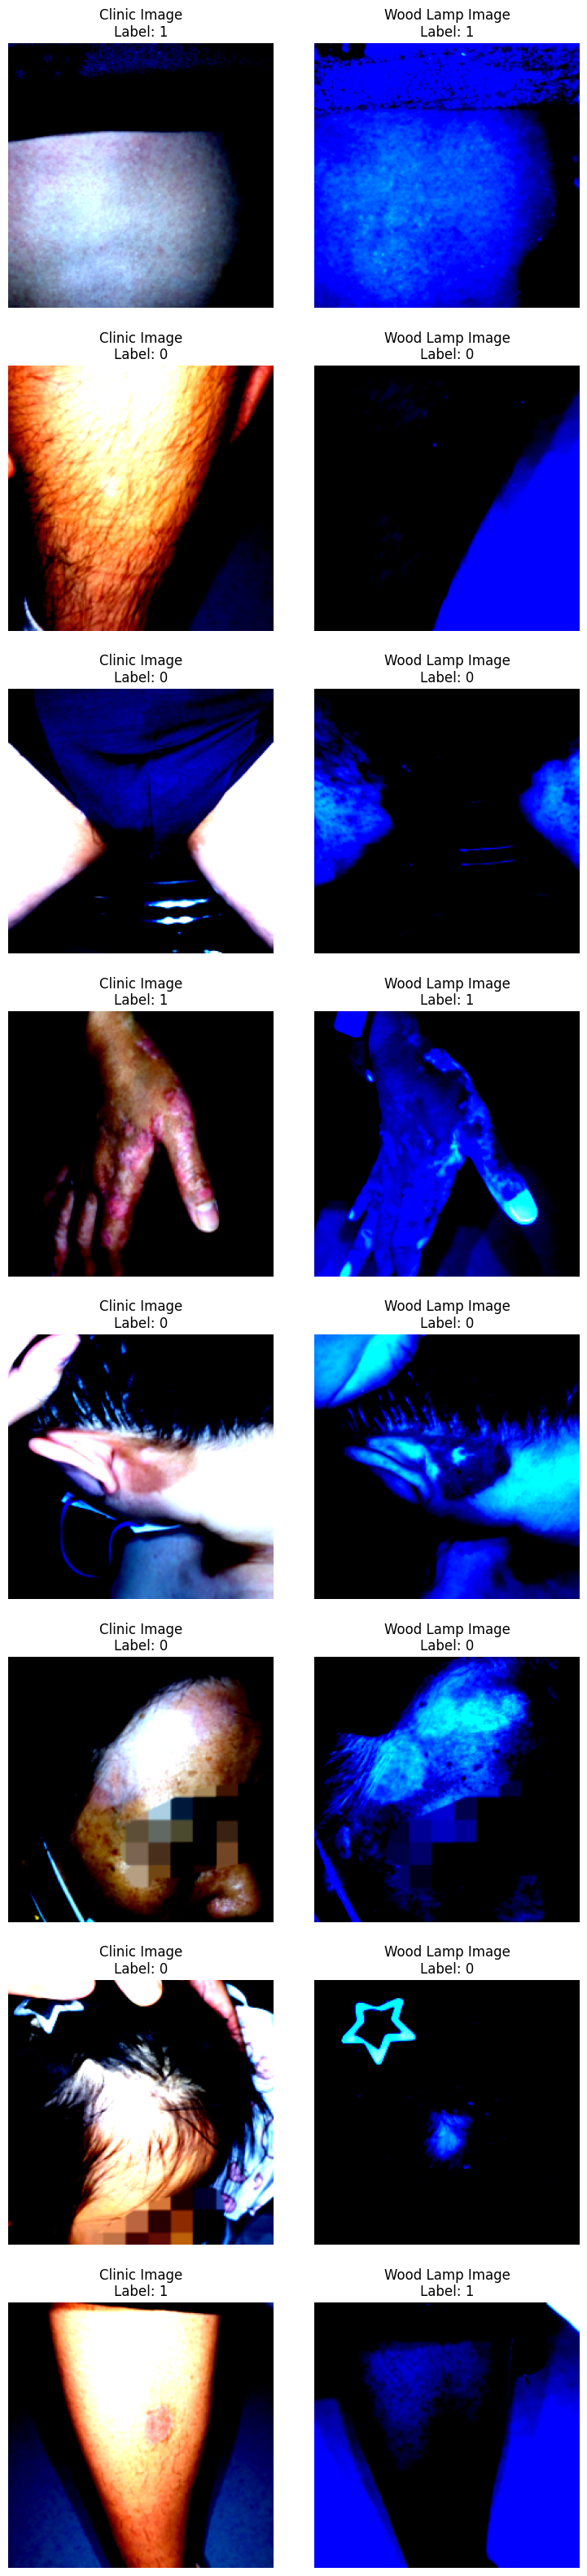

In [ ]:
import random
import matplotlib.pyplot as plt

class VitiligoDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)
        self.transform = transform
        self.grouped = self.data.groupby(['pair_id', 'stability'])

    def __len__(self):
        return len(self.grouped.groups)

    def __getitem__(self, idx):
        pair_id, stability = list(self.grouped.groups.keys())[idx]
        pairs = self.grouped.get_group((pair_id, stability))
        clinic = pairs[pairs['image_type'] == 'clinic']
        wood = pairs[pairs['image_type'] == 'wood']
        clinic_path = clinic['image_path'].values[0]
        wood_path = wood['image_path'].values[0]
        clinic_image = Image.open(clinic_path).convert('RGB')
        wood_image = Image.open(wood_path).convert('RGB')
        if self.transform:
            clinic_image = self.transform(clinic_image)
            wood_image = self.transform(wood_image)
        label = 1 if stability == 'stable' else 0
        label = torch.tensor(label, dtype=torch.long)
        return clinic_image, wood_image, label


class AugmentedMixedDataset(Dataset):
    def __init__(self, original_dataset, transform, original_transform, augment_ratio=4):

        self.original_dataset = original_dataset
        self.transform = transform  
        self.original_transform = original_transform  
        self.augment_ratio = augment_ratio
        self.original_indices = list(range(len(original_dataset)))
        self.augmented_indices = list(range(len(original_dataset))) * augment_ratio
    
    def __len__(self):
        return len(self.original_indices) + len(self.augmented_indices)
    
    def __getitem__(self, idx):
        is_original = idx < len(self.original_indices)
        
        if is_original:
            idx_in_original = idx
            c_img, w_img, label = self.original_dataset[idx_in_original]
            c_img = self.original_transform(c_img)
            w_img = self.original_transform(w_img)
        else:
            idx_in_augmented = idx - len(self.original_indices)
            original_idx = self.augmented_indices[idx_in_augmented]
            c_img, w_img, label = self.original_dataset[original_idx]
            c_img_pil = transforms.ToPILImage()(c_img)
            w_img_pil = transforms.ToPILImage()(w_img)
            c_img_aug, w_img_aug = self.transform(c_img_pil, w_img_pil)
            c_img, w_img = c_img_aug, w_img_aug
        
        return c_img, w_img, label


class DualImageTransform:
    def __init__(self, transform):
        self.transform = transform
    
    def __call__(self, img1, img2):
        seed = random.randint(0, 2**32 - 1)
        for t in self.transform.transforms:
            random.seed(seed)
            img1 = t(img1)
            random.seed(seed)
            img2 = t(img2)
        return img1, img2


class LabColorTransform:
    def __init__(self, brightness_scale=0.1, a_scale=0.2, b_scale=0.2, p=0.5):
        self.brightness_scale = brightness_scale
        self.a_scale = a_scale
        self.b_scale = b_scale
        self.p = p
    
    def __call__(self, img):
        if random.random() > self.p:
            return img
        
        lab_img = img.convert('LAB')
        lab_array = np.array(lab_img)
        L, a, b = lab_array[:, :, 0], lab_array[:, :, 1], lab_array[:, :, 2]
        
        brightness_shift = random.uniform(-self.brightness_scale, self.brightness_scale)
        L = np.clip(L + brightness_shift * 100, 0, 100)
        
        a_shift = random.uniform(-self.a_scale, self.a_scale)
        a = np.clip(a + a_shift * 127, -128, 127)
        
        b_shift = random.uniform(-self.b_scale, self.b_scale)
        b = np.clip(b + b_shift * 127, -128, 127)
        
        lab_array[:, :, 0] = L
        lab_array[:, :, 1] = a
        lab_array[:, :, 2] = b
        return Image.fromarray(lab_array, mode='LAB').convert('RGB')


def create_timm_transforms(backbone, train=True):

    pretrained_cfg = backbone.pretrained_cfg if hasattr(backbone, 'pretrained_cfg') else {}

    data_config = timm.data.resolve_data_config(pretrained_cfg, verbose=False)

    
    if train:

        transform = timm.data.create_transform(
            input_size=data_config['input_size'],
            is_training=True,
            color_jitter=data_config.get('color_jitter', 0.4),
            auto_augment=data_config.get('auto_augment', None),
            re_prob=data_config.get('reprob', 0.25),
            re_mode=data_config.get('remode', 'pixel'),
            re_count=data_config.get('recount', 1),
            mean=data_config.get('mean', timm.data.constants.IMAGENET_DEFAULT_MEAN),
            std=data_config.get('std', timm.data.constants.IMAGENET_DEFAULT_STD),
        )
    else:

        transform = timm.data.create_transform(
            input_size=data_config['input_size'],
            is_training=False,
            mean=data_config.get('mean', timm.data.constants.IMAGENET_DEFAULT_MEAN),
            std=data_config.get('std', timm.data.constants.IMAGENET_DEFAULT_STD),
        )
    return transform


def get_augmentation_transform(timm_train_transform, img_size=None):

    if img_size is None:
        img_size = timm_train_transform.transforms[0].size[0]  
    
    timm_transform_list = []
    for t in timm_train_transform.transforms:
        if isinstance(t, (transforms.ToTensor, transforms.Normalize)):
            break
        timm_transform_list.append(t)
    transform = transforms.Compose([
        *timm_transform_list,
        transforms.RandomRotation(degrees=15),
        LabColorTransform(),  
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.3),
        transforms.RandomApply([transforms.GaussianBlur(kernel_size=3)], p=0.2),
        transforms.RandomApply([transforms.RandomAdjustSharpness(sharpness_factor=2)], p=0.2),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=timm.data.constants.IMAGENET_DEFAULT_MEAN,
            std=timm.data.constants.IMAGENET_DEFAULT_STD
        )
    ])
    return transform



def visualize_dataset(dataset, num_samples=8, figsize_per_sample=(4, 4), dpi=100):

 
    total_figsize = (figsize_per_sample[0] * 2, figsize_per_sample[1] * num_samples)
    
    plt.figure(figsize=total_figsize, dpi=dpi)
    for i in range(num_samples):
        c_img, w_img, label = dataset[i]
        
 
        mean = np.array(timm.data.constants.IMAGENET_DEFAULT_MEAN)
        std = np.array(timm.data.constants.IMAGENET_DEFAULT_STD)
        c_img_np = c_img.permute(1, 2, 0).cpu().numpy()
        w_img_np = w_img.permute(1, 2, 0).cpu().numpy()
        
        c_img_np = c_img_np * std + mean
        w_img_np = w_img_np * std + mean
        c_img_np = np.clip(c_img_np, 0, 1)
        w_img_np = np.clip(w_img_np, 0, 1)
        
    
        plt.subplot(num_samples, 2, 2*i+1)
        plt.imshow(c_img_np)
        plt.title(f'Clinic Image\nLabel: {label.item()}', fontsize=12)
        plt.axis('off')
        
   
        plt.subplot(num_samples, 2, 2*i+2)
        plt.imshow(w_img_np)
        plt.title(f'Wood Lamp Image\nLabel: {label.item()}', fontsize=12)
        plt.axis('off')
    
   
    plt.tight_layout(pad=2.0)

backbone = timm.create_model("convnextv2_tiny", checkpoint_path='../../../../outputs/checkpoints/proposed/pytorch_model.bin')
    
original_dataset = VitiligoDataset(csv_file='../../../../datasets/data.csv')
print(f"Original datasize: {len(original_dataset)} pairs")


train_size = int(0.8 * len(original_dataset))
val_size = len(original_dataset) - train_size
train_dataset_original, val_dataset_original = torch.utils.data.random_split(
    original_dataset, [train_size, val_size], generator=torch.Generator().manual_seed(42)
)
print(f"train_dataset_original: {len(train_dataset_original)} pairs")
print(f"val_dataset_original: {len(val_dataset_original)} pairs")


timm_train_transform = create_timm_transforms(backbone, train=True)
timm_val_transform = create_timm_transforms(backbone, train=False)


train_augment_transform = get_augmentation_transform(timm_train_transform)
train_original_transform = timm_val_transform  



train_dataset = AugmentedMixedDataset(
    original_dataset=train_dataset_original,
    transform=DualImageTransform(train_augment_transform),
    original_transform=train_original_transform,
    augment_ratio=Config.augment_ratio)

print(f"train_dataset: {len(train_dataset)} pairs")
val_dataset = val_dataset_original
val_dataset.dataset.transform = timm_val_transform


visualize_dataset(train_dataset)


train_loader = DataLoader(train_dataset, batch_size=Config.batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=Config.batch_size, shuffle=False)




In [ ]:
backbone = timm.create_model("convnextv2_tiny", checkpoint_path='../../../../outputs/checkpoints/proposed/pytorch_model.bin')

def count_layers(model, depth=0):
    layer_count = 0
    for _, child in model.named_children():
        layer_count += 1
        layer_count += count_layers(child, depth + 1)
    return layer_count

total_layers = count_layers(backbone)
print(f"\nTotal layers (recursive count): {total_layers}")


Total layers (recursive count): 248


dataloader

In [15]:
from collections import Counter




train_labels = []
for _, _, label in train_dataset:
    train_labels.append(label.item())

class_counts = Counter(train_labels)
total_samples = len(train_labels)
class_percentages = {cls: count / total_samples * 100 for cls, count in class_counts.items()}


print("Distribution:")
for cls, count in class_counts.items():
    print(f"Classes {cls}: {count} samples ({class_percentages[cls]:.2f}%)")


Distribution:
Classes 1: 1255 samples (51.86%)
Classes 0: 1165 samples (48.14%)


Model

In [ ]:
class ConvQKVAttention(nn.Module):

    def __init__(self, in_channels, out_channels=None):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels or in_channels
        
 
        self.q_conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.k_conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.v_conv = nn.Conv2d(2 * in_channels, out_channels, kernel_size=3, padding=1)
        

        self.fusion = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, kernel_size=1),
            nn.GELU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=1)
        )
    
    def forward(self, x1, x2):

        q = self.q_conv(x2) 
        k = self.k_conv(x1)  
        
   
        attention_scores = torch.sum(q * k, dim=1, keepdim=True) 
        attention_weights = torch.softmax(attention_scores, dim=1)

     
        v_input = torch.cat([x1, x2], dim=1)  
        v = self.v_conv(v_input)  
        
      
        attended_v = v * attention_weights 
        
    
        fused_features = self.fusion(attended_v)
        
        return fused_features, attention_weights



class ConvNeXtV2MAE(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        
 
        self.encoder = timm.create_model(
            "convnextv2_tiny",
            checkpoint_path='../../../../outputs/checkpoints/proposed/pytorch_model.bin')
        self.encoder.head = nn.Identity()
        for param in self.encoder.parameters():
            param.requires_grad = False
        for param in self.encoder.stages[-2:].parameters():
            param.requires_grad = True
        
        self.encoder_dim = 768
        

        self.encoder_proj = nn.Conv2d(self.encoder_dim, 384, kernel_size=1)
        
   
        decoder_dim = 384
        self.decoder_blocks = nn.Sequential(
            ConvNeXtBlock(decoder_dim, drop_path=0.0),
            ConvNeXtBlock(decoder_dim, drop_path=0.0),
            ConvNeXtBlock(decoder_dim, drop_path=0.0),
            ConvNeXtBlock(decoder_dim, drop_path=0.0),
        )
        
      
        self.upsample = nn.Sequential(
            nn.ConvTranspose2d(decoder_dim, decoder_dim//2, kernel_size=2, stride=2),
            ConvNeXtBlock(decoder_dim//2, drop_path=0.0),
            nn.ConvTranspose2d(decoder_dim//2, decoder_dim//4, kernel_size=2, stride=2),
            ConvNeXtBlock(decoder_dim//4, drop_path=0.0),
            nn.ConvTranspose2d(decoder_dim//4, decoder_dim//8, kernel_size=2, stride=2),
            ConvNeXtBlock(decoder_dim//8, drop_path=0.0),
            nn.ConvTranspose2d(decoder_dim//8, decoder_dim//16, kernel_size=2, stride=2),
            ConvNeXtBlock(decoder_dim//16, drop_path=0.0),
            nn.ConvTranspose2d(decoder_dim//16, decoder_dim//32, kernel_size=2, stride=2),
            nn.Conv2d(decoder_dim//32, 3, kernel_size=1),
        )
        

        
        self.head = nn.Linear(384, 2)
        
        
        self.mask_generator = MaskGenerator(
            input_size=config.img_size,
            patch_size=config.patch_size,
            mask_ratio=config.mask_ratio
        )
        self.conv_qkv_attention = ConvQKVAttention(
            in_channels=384, out_channels=384
        )
        
    def get_global_context(self, c_img, w_img):
  
        x1 = self.encoder.forward_features(c_img) 
        x2 = self.encoder.forward_features(w_img)  
        

        x1 = self.encoder_proj(x1) 
        x2 = self.encoder_proj(x2) 
        
    
        fused_features, attention_map = self.conv_qkv_attention(x1, x2)
 
        
    
        global_features = fused_features.mean(dim=(2, 3))  
        
        return global_features, attention_map

    def forward_encoder(self, w_img, mask):

        masked_x = self.generate_masked_image(w_img, mask)

        x = self.encoder.forward_features(masked_x)  
        x = self.encoder_proj(x)  
        return x, mask
    
    def forward_decoder(self, x, mask):

        x = self.decoder_blocks(x)
        x = self.upsample(x)
        return x, mask
    
    def forward_classification(self, c_img, w_img):

        features, _ = self.get_global_context(c_img, w_img)
        logits = self.head(features)
        return logits
    
    def forward_loss(self, c_img, w_img, pred, mask, labels=None, mae_weight=1.0, cls_weight=10):

  
        p = self.config.patch_size
        h, w = w_img.shape[2]//p, w_img.shape[3]//p
        mask = torch.as_tensor(mask, dtype=torch.bool, device=pred.device)
        mask = mask.reshape(-1, 1, h, w)
        mask = F.interpolate(mask.float(), scale_factor=p, mode='nearest').bool()

        mae_loss = (pred - w_img) ** 2
        mae_loss = mae_loss.mean(dim=1)  
        mae_loss = (mae_loss * (~mask.squeeze(1))).sum() / (~mask).sum()
        
        cls_loss = 0
        if labels is not None:
            logits = self.forward_classification(c_img, w_img)
            cls_loss = F.cross_entropy(logits, labels)
        
        total_loss = mae_weight * mae_loss + cls_weight * cls_loss
        
        return {
            'total_loss': total_loss,
            'mae_loss': mae_loss,
            'cls_loss': cls_loss
        }
    
    
    def generate_masked_image(self, x, mask):

        p = self.config.patch_size
        h, w = x.shape[2]//p, x.shape[3]//p
        mask = torch.as_tensor(mask, dtype=torch.float32, device=x.device)
        mask = mask.reshape(-1, 1, h, w)
        mask = F.interpolate(mask, scale_factor=p, mode='nearest')
        return x * mask
    
    
    def forward(self, c_img, w_img, labels):

        mask = self.mask_generator()
        mask = mask.to(w_img.device)
        mask = mask.repeat(w_img.shape[0], 1)
 
        
        x, mask = self.forward_encoder(w_img, mask)
        
        pred, mask = self.forward_decoder(x, mask)
    
        loss = self.forward_loss(c_img, w_img, pred, mask, labels=labels)
        return loss, pred, mask


class MaskGenerator:
    def __init__(self, input_size=Config.img_size, patch_size=16, mask_ratio=0.75):
        self.input_size = input_size
        self.patch_size = patch_size
        self.mask_ratio = mask_ratio
        self.num_patches = (input_size // patch_size) ** 2
        self.num_masked = int(self.num_patches * mask_ratio)
    
    def __call__(self):

        mask_indices = np.random.permutation(self.num_patches)[:self.num_masked]
        mask = np.ones(self.num_patches, dtype=np.int64)
        mask[mask_indices] = 0  
        mask = torch.tensor(mask, dtype=torch.bool)
        return mask


Visulization

In [17]:
import matplotlib.pyplot as plt
import cv2


def visualize(model, data_loader, config, num_samples=4, save_path=None):

    model.eval()
    device = config.device
    model = model.to(device)
    
    with torch.no_grad():

        for i, (clinic_images, wood_images, labels) in enumerate(data_loader):
            if i >= 1:
                break
                

            clinic_images = clinic_images.to(device)[:num_samples]
            wood_images = wood_images.to(device)[:num_samples]
            labels = labels.to(device)[:num_samples]
            

            _, pred, mask = model(clinic_images, wood_images, labels)
            _, attention_maps = model.get_global_context(clinic_images, wood_images)
            

            mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1)
            std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1)
 
            images = wood_images.detach().cpu()
            images = images * std + mean
            pred = pred.detach().cpu()
            pred = pred * std + mean
            

            p = config.patch_size
            h, w = images.shape[2] // p, images.shape[3] // p
            mask_cpu = mask[0].detach().cpu().reshape(1, 1, h, w)
            mask_cpu = F.interpolate(mask_cpu.float(), size=(images.shape[2], images.shape[3]), mode='nearest')
            mask_cpu = mask_cpu.repeat(1, 3, 1, 1)
            

            attention_maps = attention_maps.detach().cpu()
            wood_images_np = wood_images.detach().cpu() * std + mean
            wood_images_np = wood_images_np.clamp(0, 1)
            
    
            fig, axes = plt.subplots(num_samples, 4, figsize=(20, 5 * num_samples))
            
            for i in range(num_samples):

                img_original = images[i].permute(1, 2, 0).numpy()
                axes[i, 0].imshow(img_original.clip(0, 1))
                axes[i, 0].set_title("Original Image")
                axes[i, 0].axis('off')
                

                masked_img = images[i] * mask_cpu[0].numpy()
                axes[i, 1].imshow(masked_img.permute(1, 2, 0).clip(0, 1))
                axes[i, 1].set_title("Masked Image")
                axes[i, 1].axis('off')
                

                img_reconstructed = pred[i].permute(1, 2, 0).numpy()
                axes[i, 2].imshow(img_reconstructed.clip(0, 1))
                axes[i, 2].set_title("Reconstructed Image")
                axes[i, 2].axis('off')
                

                attn_map = attention_maps[i, 0].numpy()
                attn_map = (attn_map - attn_map.min()) / (attn_map.max() - attn_map.min() + 1e-8)
                attn_resized = cv2.resize(attn_map, (img_original.shape[1], img_original.shape[0]))
                
                heatmap = cv2.applyColorMap((attn_resized * 255).astype(np.uint8), cv2.COLORMAP_JET)
                heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0
                overlay = cv2.addWeighted(img_original, 0.6, heatmap, 0.4, 0)
                
                axes[i, 3].imshow(overlay)
                axes[i, 3].set_title("Attention Heatmap")
                axes[i, 3].axis('off')
            
            plt.tight_layout()
            

            if save_path:
                plt.savefig(save_path, dpi=300, bbox_inches='tight')
            else:
                plt.show()
            
            break

C:\Temp\ipykernel_26728\3445480146.py:58: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  masked_img = images[i] * mask_cpu[0].numpy()
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.2604674..1.7260836].


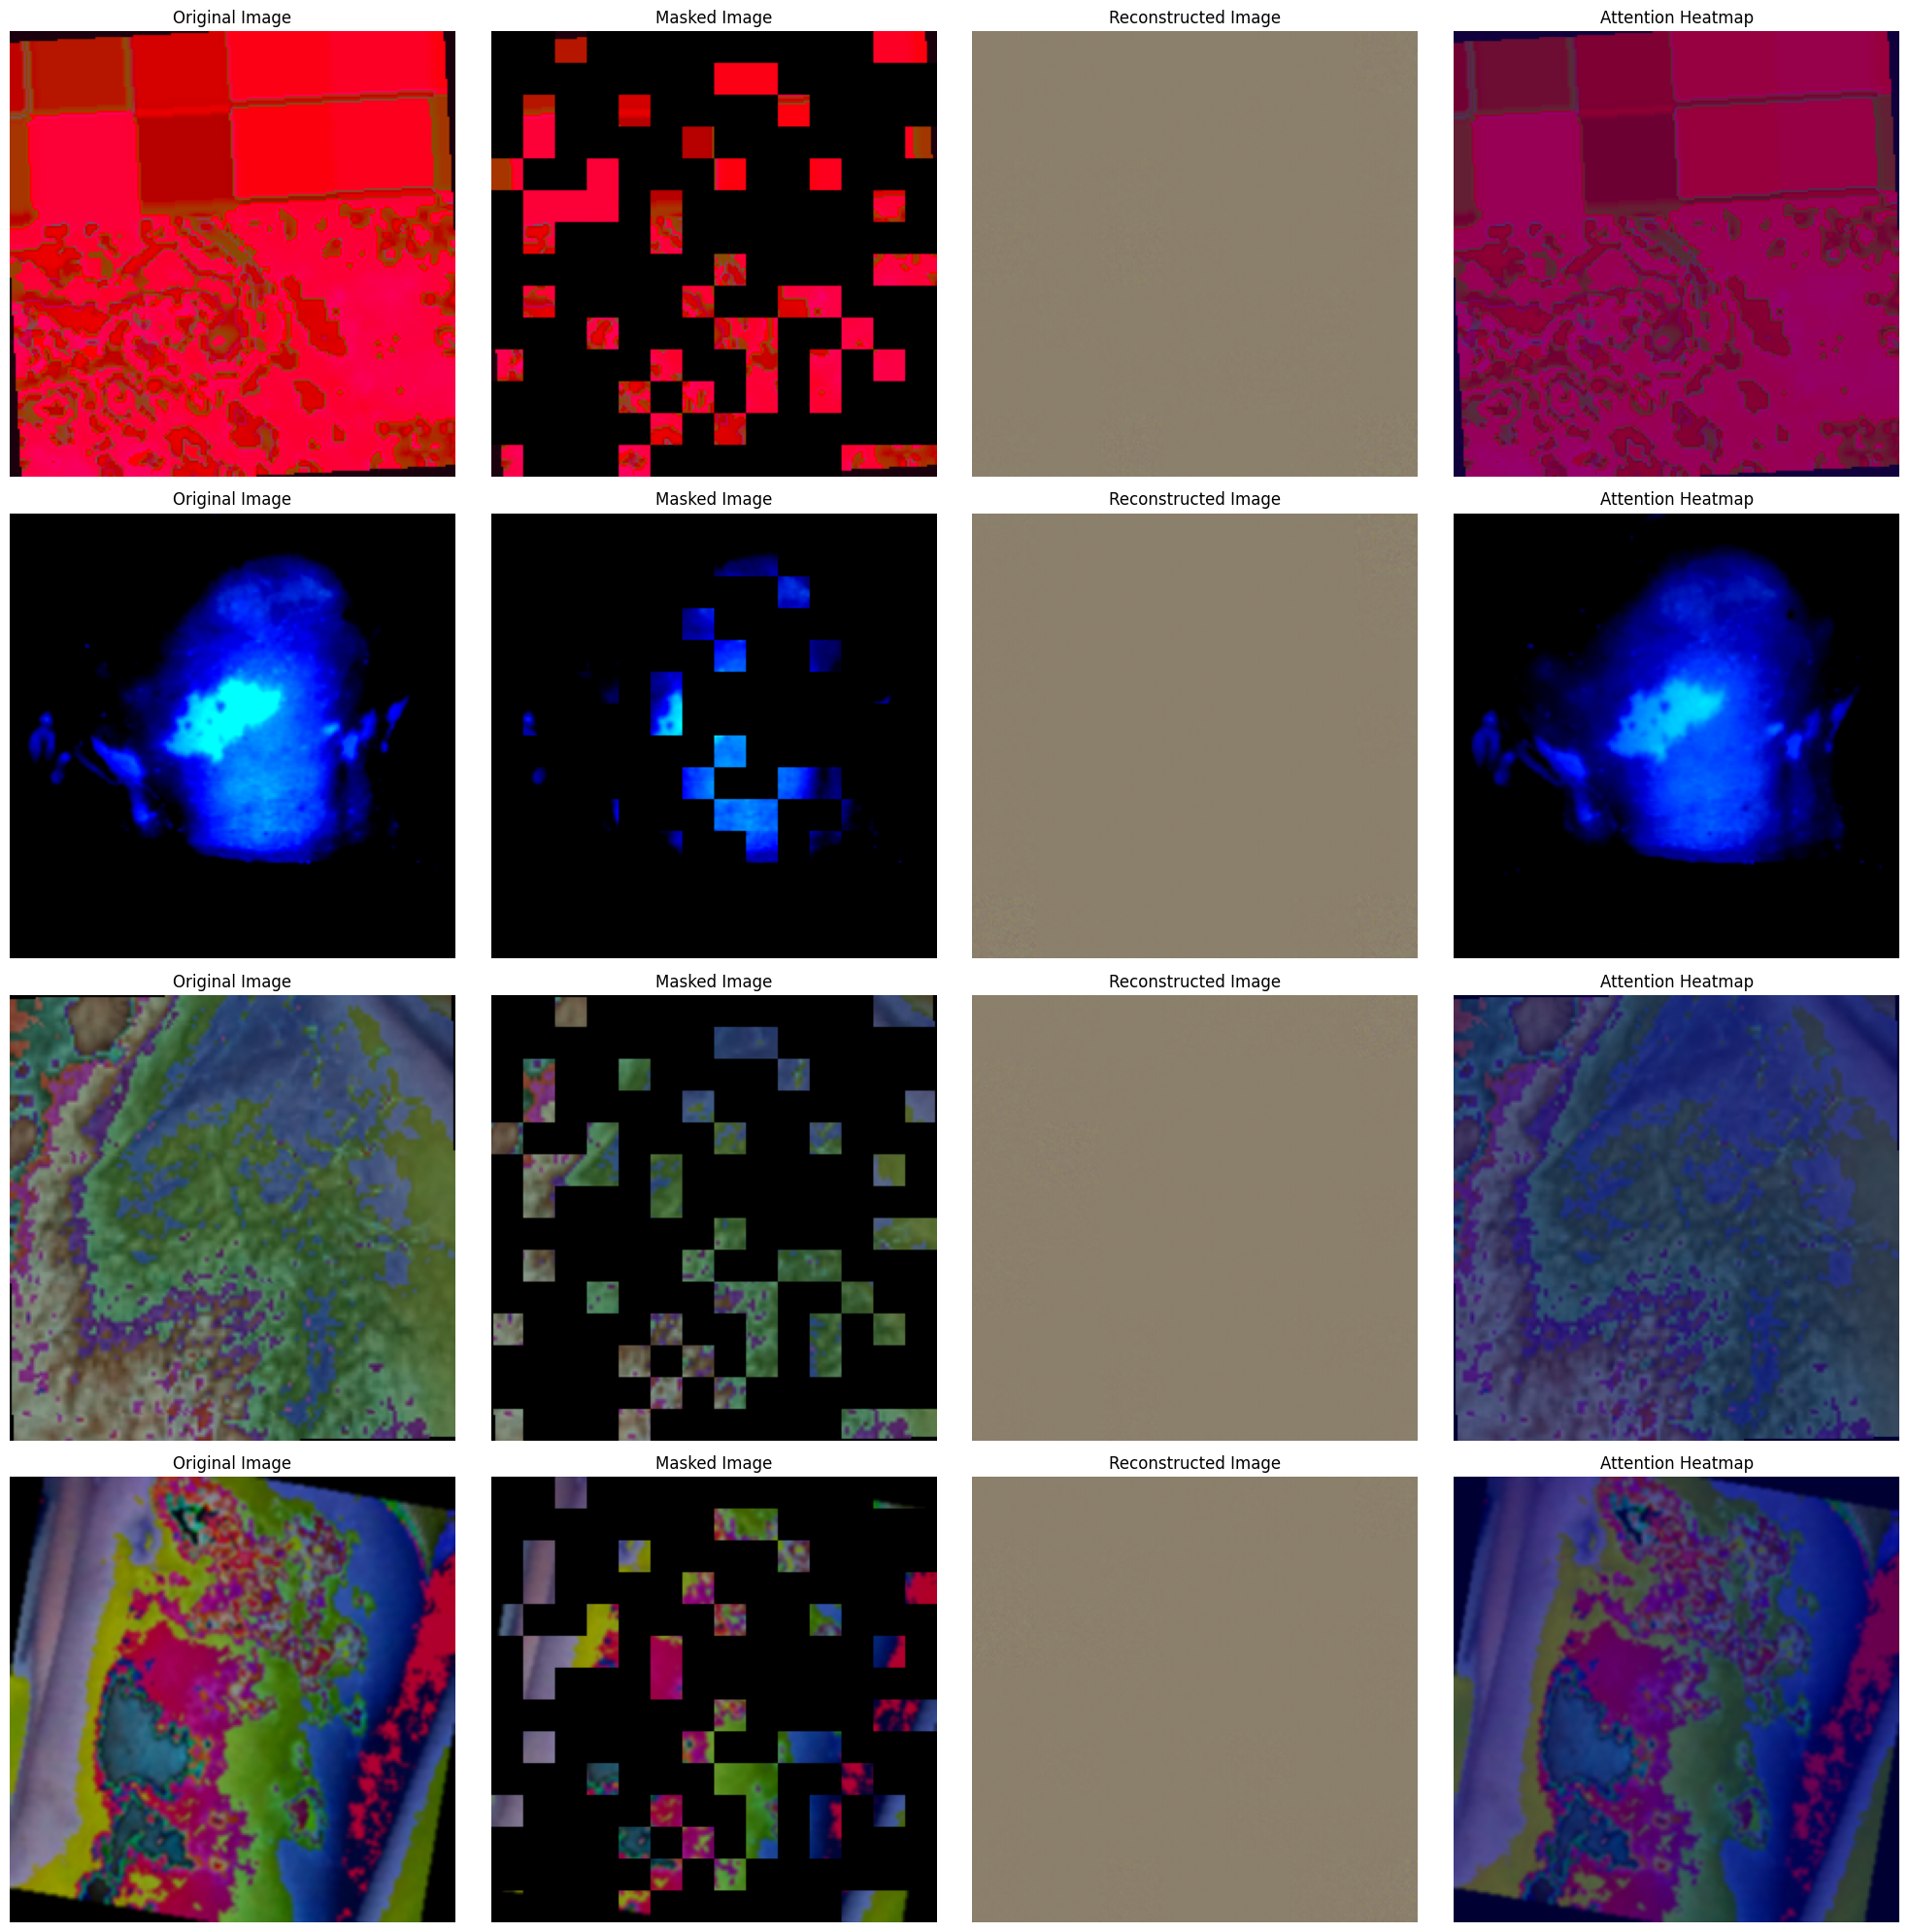

In [18]:
model = ConvNeXtV2MAE(Config).to(Config.device)

visualize(model, train_loader, Config, num_samples=4, save_path=None)

Test

In [19]:
config = Config()
model = ConvNeXtV2MAE(config).to(config.device)
model.train()
c_img, w_img, labels = next(iter(train_loader))
c_img, w_img, labels = c_img.to(config.device), w_img.to(config.device), labels.to(config.device)
loss_dict, _, _ = model(c_img, w_img, labels)
print(loss_dict)



{'total_loss': tensor(18.2724, device='cuda:0', grad_fn=<AddBackward0>), 'mae_loss': tensor(11.4382, device='cuda:0', grad_fn=<DivBackward0>), 'cls_loss': tensor(0.6834, device='cuda:0', grad_fn=<NllLossBackward0>)}


In [20]:
from sklearn.metrics import precision_score, confusion_matrix 
model.eval()
all_labels = []
all_preds = []

with torch.no_grad():
    for c_img, w_img, labels in val_loader:
        c_img, w_img, labels = c_img.to(config.device), w_img.to(config.device), labels.to(config.device)
        logits = model.forward_classification(c_img, w_img)
        preds = torch.argmax(logits, dim=1)
        
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())



for i, (label, pred) in enumerate(zip(all_labels, all_preds)):
    print(f"sample {i+1}: Label={label}, Pred={pred}")


precision = precision_score(all_labels, all_preds)
cm = confusion_matrix(all_labels, all_preds)
tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp)

print(f"precision: {precision:.4f}")
print(f"specificity: {specificity:.4f}")
print(f"cm:\n{cm}")


sample 1: Label=0, Pred=0
sample 2: Label=1, Pred=1
sample 3: Label=0, Pred=0
sample 4: Label=1, Pred=1
sample 5: Label=0, Pred=0
sample 6: Label=0, Pred=1
sample 7: Label=1, Pred=0
sample 8: Label=1, Pred=0
sample 9: Label=1, Pred=0
sample 10: Label=0, Pred=1
sample 11: Label=1, Pred=1
sample 12: Label=0, Pred=1
sample 13: Label=1, Pred=1
sample 14: Label=1, Pred=0
sample 15: Label=0, Pred=1
sample 16: Label=1, Pred=0
sample 17: Label=1, Pred=1
sample 18: Label=0, Pred=1
sample 19: Label=1, Pred=1
sample 20: Label=1, Pred=0
sample 21: Label=0, Pred=1
sample 22: Label=1, Pred=0
sample 23: Label=0, Pred=1
sample 24: Label=1, Pred=1
sample 25: Label=0, Pred=0
sample 26: Label=0, Pred=1
sample 27: Label=0, Pred=0
sample 28: Label=0, Pred=1
sample 29: Label=1, Pred=1
sample 30: Label=1, Pred=1
sample 31: Label=0, Pred=1
sample 32: Label=1, Pred=0
sample 33: Label=1, Pred=1
sample 34: Label=0, Pred=0
sample 35: Label=0, Pred=0
sample 36: Label=1, Pred=0
sample 37: Label=0, Pred=0
sample 38:

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from tqdm import tqdm
import os
import time


config = Config()
model = ConvNeXtV2MAE(config).to(config.device)

optimizer = optim.AdamW(
    model.parameters(), 
    lr=config.learning_rate, 
    weight_decay=config.weight_decay
)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=40
)

start_epoch = 0
best_val_metrics = 0.0
best_val_precision = 0.0
best_val_specificity = 0.0
best_val_f1 = 0.0
best_val_auc = 0.0
best_val_recall = 0.0
best_val_accuracy = 0.0
counter = 0
train_losses = []
train_precisions = []
train_specificities = []
train_f1s = []
train_aucs = []
train_recalls = []
train_accuracies = []
val_precisions = []
val_specificities = []
val_f1s = []
val_aucs = []
val_recalls = []
val_accuracies = []

checkpoint_path = os.path.join(config.save_dir, 'checkpoint.pth')
best_model_dir = config.save_dir
os.makedirs(best_model_dir, exist_ok=True)

if config.resume_training:
    checkpoint = torch.load(config.best_model_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    start_epoch = checkpoint['epoch']
    best_val_precision = checkpoint['best_val_precision']
    best_val_specificity = checkpoint['best_val_specificity']
    best_val_f1 = checkpoint.get('best_val_f1', 0.0)
    best_val_auc = checkpoint.get('best_val_auc', 0.0)
    best_val_recall = checkpoint.get('best_val_recall', 0.0)
    best_val_accuracy = checkpoint.get('best_val_accuracy', 0.0)
    train_losses = checkpoint.get('train_losses', [])
    train_precisions = checkpoint.get('train_precisions', [])
    train_specificities = checkpoint.get('train_specificities', [])
    train_f1s = checkpoint.get('train_f1s', [])
    train_aucs = checkpoint.get('train_aucs', [])
    train_recalls = checkpoint.get('train_recalls', [])
    train_accuracies = checkpoint.get('train_accuracies', [])
    val_precisions = checkpoint.get('val_precisions', [])
    val_specificities = checkpoint.get('val_specificities', [])
    val_f1s = checkpoint.get('val_f1s', [])
    val_aucs = checkpoint.get('val_aucs', [])
    val_recalls = checkpoint.get('val_recalls', [])
    val_accuracies = checkpoint.get('val_accuracies', [])

for epoch in range(start_epoch, config.num_epochs):
    model.train()
    epoch_loss = 0.0
    all_mae = []
    all_cls = []
    all_preds = []
    all_labels = []
    all_probs = []
    progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{config.num_epochs}')
    
    for i, (c_img, w_img, labels) in enumerate(progress_bar):
        c_img, w_img, labels = c_img.to(config.device), w_img.to(config.device), labels.to(config.device)
        optimizer.zero_grad(set_to_none=True)
        loss_dict, _, _ = model(c_img, w_img, labels)
        loss = loss_dict['total_loss']
        loss.backward()
        optimizer.step()

        logits = model.forward_classification(c_img, w_img)
        probs = torch.softmax(logits, dim=1)[:, 1]
        preds = torch.argmax(logits, dim=1)

        all_preds.extend(preds.detach().cpu().numpy())
        all_labels.extend(labels.detach().cpu().numpy())
        all_probs.extend(probs.detach().cpu().numpy())
        epoch_loss += loss.item()
        all_mae.append(loss_dict['mae_loss'].item())
        all_cls.append(loss_dict['cls_loss'].item())
        
        if (i+1) % 20 == 0 or i == len(train_loader)-1:
            cls = loss_dict['cls_loss'].item()
            progress_bar.set_postfix(loss=f"{loss.item():.4f}", cls=f"{cls:.4f}", mae=f"{loss_dict['mae_loss'].item():.4f}")

    train_loss = epoch_loss / len(train_loader)
    train_losses.append(train_loss)
    avg_cls = np.mean(all_cls)
    avg_mae = np.mean(all_mae)
    train_precision = precision_score(all_labels, all_preds)
    train_recall = recall_score(all_labels, all_preds)
    train_f1 = f1_score(all_labels, all_preds)
    train_auc = roc_auc_score(all_labels, all_probs) 
    cm = confusion_matrix(all_labels, all_preds)
    tn, fp, fn, tp = cm.ravel()
    train_specificity = tn / (tn + fp) 
    train_accuracy = (tp + tn) / (tp + tn + fp + fn) 

    train_precisions.append(train_precision)
    train_specificities.append(train_specificity)
    train_f1s.append(train_f1)
    train_aucs.append(train_auc)
    train_recalls.append(train_recall)
    train_accuracies.append(train_accuracy)
    
    print(f"\nEpoch {epoch+1} - Train: cls={avg_cls:.4f}, mae={avg_mae:.4f}, loss={train_loss:.4f}, "
          f"precision={train_precision:.4f}, specificity={train_specificity:.4f}, "
          f"recall={train_recall:.4f}, f1={train_f1:.4f}, auc={train_auc:.4f}, accuracy={train_accuracy:.4f}")


    model.eval()
    all_preds, all_labels, all_probs, all_mae_val, all_cls_val = [], [], [], [], []
    with torch.no_grad():
        for c_img, w_img, labels in val_loader:
            c_img, w_img, labels = c_img.to(config.device), w_img.to(config.device), labels.to(config.device)
            loss_dict, pred, mask = model(c_img, w_img, labels)
            logits = model.forward_classification(c_img, w_img)
            probs = torch.softmax(logits, dim=1)[:, 1]
            preds = torch.argmax(logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
            all_mae_val.append(loss_dict['mae_loss'].item())
            all_cls_val.append(loss_dict['cls_loss'].item())


    avg_cls_val = np.mean(all_cls_val)
    avg_mae_val = np.mean(all_mae_val)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)

    if len(np.unique(all_labels)) > 1:
        auc = roc_auc_score(all_labels, all_probs)
    else:
        auc = 0.0
    cm = confusion_matrix(all_labels, all_preds)

    if cm.shape == (2, 2):
        tn, fp, fn, tp = cm.ravel()
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0
        accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0.0
    else:
        specificity = 0.0
        accuracy = 0.0

    val_precisions.append(precision)
    val_specificities.append(specificity)
    val_f1s.append(f1)
    val_aucs.append(auc)
    val_recalls.append(recall)
    val_accuracies.append(accuracy)
    
    print(f"Epoch {epoch+1} - Val: cls={avg_cls_val:.4f}, mae={avg_mae_val:.4f}, "
          f"precision={precision:.4f}, specificity={specificity:.4f}, "
          f"recall={recall:.4f}, f1={f1:.4f}, auc={auc:.4f}, accuracy={accuracy:.4f}")
    
    composite_metric = precision * specificity * recall
    scheduler.step(composite_metric)

    is_best = composite_metric > best_val_metrics
    if is_best:
        best_val_metrics = composite_metric
        best_val_precision = precision
        best_val_specificity = specificity
        best_val_f1 = f1
        best_val_auc = auc
        best_val_recall = recall
        best_val_accuracy = accuracy
        counter = 0
        model_path = os.path.join(best_model_dir,
                                 f"best_model_p{precision:.4f}_s{specificity:.4f}_f1{f1:.4f}.pth")
        torch.save(model.state_dict(), model_path)
        print(f"★ Saved best model: {os.path.basename(model_path)}")
    else:
        counter += 1

    if (epoch+1) % 5 == 0 or is_best:
        checkpoint = {
            'epoch': epoch+1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'best_val_precision': best_val_precision,
            'best_val_specificity': best_val_specificity,
            'best_val_f1': best_val_f1,
            'best_val_auc': best_val_auc,
            'best_val_recall': best_val_recall,
            'best_val_accuracy': best_val_accuracy,
            'train_losses': train_losses,
            'train_precisions': train_precisions,
            'train_specificities': train_specificities,
            'train_f1s': train_f1s,
            'train_aucs': train_aucs,
            'train_recalls': train_recalls,
            'train_accuracies': train_accuracies,
            'val_precisions': val_precisions,
            'val_specificities': val_specificities,
            'val_f1s': val_f1s,
            'val_aucs': val_aucs,
            'val_recalls': val_recalls,
            'val_accuracies': val_accuracies,
        }
        torch.save(checkpoint, checkpoint_path)
        print(f"Checkpoint saved at epoch {epoch+1}")

    if counter >= config.patience:
        print(f"Early stopping at epoch {epoch+1}: No improvement in composite metric for {config.patience} epochs")
        break

print(f"Training completed. Best metrics: precision={best_val_precision:.4f}, specificity={best_val_specificity:.4f}, "
      f"f1={best_val_f1:.4f}, auc={best_val_auc:.4f}, recall={best_val_recall:.4f}, accuracy={best_val_accuracy:.4f}")

def plot_training_metrics(train_losses, train_precisions, train_specificities, train_f1s, train_aucs, train_recalls, train_accuracies,
                         val_precisions, val_specificities, val_f1s, val_aucs, val_recalls, val_accuracies):
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 18))

    ax1.plot(train_losses)
    ax1.set_title('Training Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')

    ax2.plot(train_precisions, label='Precision (Train)')
    ax2.plot(train_specificities, label='Specificity (Train)')
    ax2.plot(train_f1s, label='F1 Score (Train)')
    ax2.plot(train_aucs, label='AUC (Train)')
    ax2.plot(train_recalls, label='Recall (Train)')
    ax2.plot(train_accuracies, label='Accuracy (Train)')
    ax2.set_title('Training Metrics')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Metric Value')
    ax2.legend()

    ax3.plot(val_precisions, label='Precision (Val)')
    ax3.plot(val_specificities, label='Specificity (Val)')
    ax3.plot(val_f1s, label='F1 Score (Val)')
    ax3.plot(val_aucs, label='AUC (Val)')
    ax3.plot(val_recalls, label='Recall (Val)')
    ax3.plot(val_accuracies, label='Accuracy (Val)')
    ax3.set_title('Validation Metrics')
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('Metric Value')
    ax3.legend()
    
    plt.tight_layout()
    plt.savefig(os.path.join(config.save_dir, 'metrics.png'))
    plt.show()

plot_training_metrics(train_losses, train_precisions, train_specificities, train_f1s, train_aucs, train_recalls, train_accuracies,
                     val_precisions, val_specificities, val_f1s, val_aucs, val_recalls, val_accuracies)

Epoch 1/30: 100%|██████████| 152/152 [13:31<00:00,  5.34s/it, cls=1.0602, loss=14.3935, mae=3.7918]



Epoch 1 - Train: cls=0.6766, mae=7.1897, loss=13.9559
Epoch 1 - Val: cls=1.0602, mae=3.7918, precision=0.9375, specificity=0.9846
★ Saved best model: best_model_p0.9375_s0.9846.pth
Checkpoint saved at epoch 1


Epoch 2/30: 100%|██████████| 152/152 [14:59<00:00,  5.92s/it, cls=0.1442, loss=3.3308, mae=1.8888] 



Epoch 2 - Train: cls=0.5519, mae=4.1118, loss=9.6303
Epoch 2 - Val: cls=0.1442, mae=1.8888, precision=0.7333, specificity=0.7538
★ Saved best model: best_model_p0.7333_s0.7538.pth
Checkpoint saved at epoch 2


Epoch 3/30: 100%|██████████| 152/152 [11:32<00:00,  4.55s/it, cls=0.1771, loss=3.4122, mae=1.6414]



Epoch 3 - Train: cls=0.4416, mae=3.9543, loss=8.3707
Epoch 3 - Val: cls=0.1771, mae=1.6414, precision=0.7419, specificity=0.7538
★ Saved best model: best_model_p0.7419_s0.7538.pth
Checkpoint saved at epoch 3


Epoch 4/30: 100%|██████████| 152/152 [11:15<00:00,  4.44s/it, cls=0.1916, loss=3.3366, mae=1.4202] 



Epoch 4 - Train: cls=0.3305, mae=3.7365, loss=7.0413
Epoch 4 - Val: cls=0.1916, mae=1.4202, precision=0.8113, specificity=0.8462
★ Saved best model: best_model_p0.8113_s0.8462.pth
Checkpoint saved at epoch 4


Epoch 5/30: 100%|██████████| 152/152 [11:28<00:00,  4.53s/it, cls=0.0046, loss=6.6595, mae=6.6130] 



Epoch 5 - Train: cls=0.2759, mae=3.5980, loss=6.3567
Epoch 5 - Val: cls=0.0046, mae=6.6130, precision=0.8125, specificity=0.9077
★ Saved best model: best_model_p0.8125_s0.9077.pth
Checkpoint saved at epoch 5


Epoch 6/30: 100%|██████████| 152/152 [11:37<00:00,  4.59s/it, cls=0.0056, loss=2.5317, mae=2.4754]



Epoch 6 - Train: cls=0.2463, mae=3.3657, loss=5.8284
Epoch 6 - Val: cls=0.0056, mae=2.4754, precision=0.7963, specificity=0.8308
★ Saved best model: best_model_p0.7963_s0.8308.pth
Checkpoint saved at epoch 6


Epoch 7/30: 100%|██████████| 152/152 [11:15<00:00,  4.44s/it, cls=0.1188, loss=2.3535, mae=1.1656]



Epoch 7 - Train: cls=0.2082, mae=3.2894, loss=5.3717
Epoch 7 - Val: cls=0.1188, mae=1.1656, precision=0.8333, specificity=0.9077
★ Saved best model: best_model_p0.8333_s0.9077.pth
Checkpoint saved at epoch 7


Epoch 8/30: 100%|██████████| 152/152 [11:16<00:00,  4.45s/it, cls=0.0020, loss=5.6572, mae=5.6371]



Epoch 8 - Train: cls=0.1490, mae=3.2470, loss=4.7369
Epoch 8 - Val: cls=0.0020, mae=5.6371, precision=0.8571, specificity=0.9077
★ Saved best model: best_model_p0.8571_s0.9077.pth
Checkpoint saved at epoch 8


Epoch 9/30: 100%|██████████| 152/152 [11:15<00:00,  4.44s/it, cls=0.0239, loss=4.6910, mae=4.4516]



Epoch 9 - Train: cls=0.1273, mae=3.1897, loss=4.4630
Epoch 9 - Val: cls=0.0239, mae=4.4516, precision=0.8810, specificity=0.9231
★ Saved best model: best_model_p0.8810_s0.9231.pth
Checkpoint saved at epoch 9


Epoch 10/30: 100%|██████████| 152/152 [11:15<00:00,  4.45s/it, cls=0.0029, loss=1.1914, mae=1.1619]



Epoch 10 - Train: cls=0.1431, mae=3.1312, loss=4.5624
Epoch 10 - Val: cls=0.0029, mae=1.1619, precision=0.8889, specificity=0.9385
★ Saved best model: best_model_p0.8889_s0.9385.pth
Checkpoint saved at epoch 10


Epoch 11/30: 100%|██████████| 152/152 [11:23<00:00,  4.50s/it, cls=0.0973, loss=1.6176, mae=0.6450]



Epoch 11 - Train: cls=0.1215, mae=3.0383, loss=4.2534
Epoch 11 - Val: cls=0.0973, mae=0.6450, precision=0.8636, specificity=0.9077
★ Saved best model: best_model_p0.8636_s0.9077.pth
Checkpoint saved at epoch 11


Epoch 12/30: 100%|██████████| 152/152 [11:29<00:00,  4.54s/it, cls=0.0007, loss=1.4577, mae=1.4511]



Epoch 12 - Train: cls=0.1101, mae=2.8738, loss=3.9751
Epoch 12 - Val: cls=0.0007, mae=1.4511, precision=0.8611, specificity=0.9231
★ Saved best model: best_model_p0.8611_s0.9231.pth
Checkpoint saved at epoch 12


Epoch 13/30: 100%|██████████| 152/152 [11:28<00:00,  4.53s/it, cls=0.0395, loss=3.7960, mae=3.4013]



Epoch 13 - Train: cls=0.1021, mae=2.5089, loss=3.5298
Epoch 13 - Val: cls=0.0395, mae=3.4013, precision=0.9024, specificity=0.9385
★ Saved best model: best_model_p0.9024_s0.9385.pth
Checkpoint saved at epoch 13


Epoch 14/30: 100%|██████████| 152/152 [11:29<00:00,  4.54s/it, cls=0.0047, loss=0.9587, mae=0.9119]



Epoch 14 - Train: cls=0.1014, mae=2.0933, loss=3.1068
Epoch 14 - Val: cls=0.0047, mae=0.9119, precision=0.8837, specificity=0.9231
★ Saved best model: best_model_p0.8837_s0.9231.pth
Checkpoint saved at epoch 14


Epoch 15/30: 100%|██████████| 152/152 [11:31<00:00,  4.55s/it, cls=0.4439, loss=5.0983, mae=0.6596]



Epoch 15 - Train: cls=0.0907, mae=1.9372, loss=2.8442
Epoch 15 - Val: cls=0.4439, mae=0.6596, precision=0.8718, specificity=0.9231
★ Saved best model: best_model_p0.8718_s0.9231.pth
Checkpoint saved at epoch 15


Epoch 16/30: 100%|██████████| 152/152 [11:35<00:00,  4.58s/it, cls=0.0048, loss=1.3850, mae=1.3374]



Epoch 16 - Train: cls=0.0821, mae=1.8609, loss=2.6818
Epoch 16 - Val: cls=0.0048, mae=1.3374, precision=0.8605, specificity=0.9077
★ Saved best model: best_model_p0.8605_s0.9077.pth
Checkpoint saved at epoch 16


Epoch 17/30: 100%|██████████| 152/152 [11:36<00:00,  4.58s/it, cls=0.9693, loss=13.0219, mae=3.3291]



Epoch 17 - Train: cls=0.0865, mae=1.8168, loss=2.6815
Epoch 17 - Val: cls=0.9693, mae=3.3291, precision=0.8947, specificity=0.9385
★ Saved best model: best_model_p0.8947_s0.9385.pth
Checkpoint saved at epoch 17


Epoch 18/30: 100%|██████████| 152/152 [11:37<00:00,  4.59s/it, cls=0.0022, loss=2.1917, mae=2.1700]



Epoch 18 - Train: cls=0.0713, mae=1.7848, loss=2.4976
Epoch 18 - Val: cls=0.0022, mae=2.1700, precision=0.8444, specificity=0.8923
★ Saved best model: best_model_p0.8444_s0.8923.pth
Checkpoint saved at epoch 18


Epoch 19/30: 100%|██████████| 152/152 [11:36<00:00,  4.58s/it, cls=0.1617, loss=4.3249, mae=2.7083]



Epoch 19 - Train: cls=0.0696, mae=1.8058, loss=2.5016
Epoch 19 - Val: cls=0.1617, mae=2.7083, precision=0.8649, specificity=0.9231
★ Saved best model: best_model_p0.8649_s0.9231.pth
Checkpoint saved at epoch 19


Epoch 20/30: 100%|██████████| 152/152 [11:37<00:00,  4.59s/it, cls=0.0000, loss=0.6862, mae=0.6861]



Epoch 20 - Train: cls=0.0659, mae=1.7024, loss=2.3619
Epoch 20 - Val: cls=0.0000, mae=0.6861, precision=0.8571, specificity=0.9077
★ Saved best model: best_model_p0.8571_s0.9077.pth
Checkpoint saved at epoch 20


Epoch 21/30: 100%|██████████| 152/152 [11:37<00:00,  4.59s/it, cls=0.0032, loss=2.4680, mae=2.4359]



Epoch 21 - Train: cls=0.0744, mae=1.6896, loss=2.4337
Epoch 21 - Val: cls=0.0032, mae=2.4359, precision=0.8409, specificity=0.8923
★ Saved best model: best_model_p0.8409_s0.8923.pth
Checkpoint saved at epoch 21


Epoch 22/30: 100%|██████████| 152/152 [11:23<00:00,  4.49s/it, cls=0.0084, loss=0.8203, mae=0.7366]



Epoch 22 - Train: cls=0.0538, mae=1.6671, loss=2.2049
Epoch 22 - Val: cls=0.0084, mae=0.7366, precision=0.8889, specificity=0.9231
★ Saved best model: best_model_p0.8889_s0.9231.pth
Checkpoint saved at epoch 22


Epoch 23/30: 100%|██████████| 152/152 [12:01<00:00,  4.75s/it, cls=0.0000, loss=1.6917, mae=1.6917]



Epoch 23 - Train: cls=0.0582, mae=1.6569, loss=2.2387
Epoch 23 - Val: cls=0.0000, mae=1.6917, precision=0.9143, specificity=0.9538
★ Saved best model: best_model_p0.9143_s0.9538.pth
Checkpoint saved at epoch 23


Epoch 24/30: 100%|██████████| 152/152 [11:25<00:00,  4.51s/it, cls=0.0151, loss=1.2534, mae=1.1027]



Epoch 24 - Train: cls=0.0693, mae=1.6684, loss=2.3613
Epoch 24 - Val: cls=0.0151, mae=1.1027, precision=0.8857, specificity=0.9385
★ Saved best model: best_model_p0.8857_s0.9385.pth
Checkpoint saved at epoch 24


Epoch 25/30: 100%|██████████| 152/152 [20:34<00:00,  8.12s/it, cls=0.1551, loss=2.1714, mae=0.6199]



Epoch 25 - Train: cls=0.0529, mae=1.6497, loss=2.1791
Epoch 25 - Val: cls=0.1551, mae=0.6199, precision=0.8947, specificity=0.9385
★ Saved best model: best_model_p0.8947_s0.9385.pth
Checkpoint saved at epoch 25


Epoch 26/30: 100%|██████████| 152/152 [11:25<00:00,  4.51s/it, cls=0.1181, loss=2.5330, mae=1.3515]



Epoch 26 - Train: cls=0.0594, mae=1.6372, loss=2.2312
Epoch 26 - Val: cls=0.1181, mae=1.3515, precision=0.8750, specificity=0.9231
★ Saved best model: best_model_p0.8750_s0.9231.pth
Checkpoint saved at epoch 26


Epoch 27/30: 100%|██████████| 152/152 [11:17<00:00,  4.46s/it, cls=0.0267, loss=1.3195, mae=1.0525]



Epoch 27 - Train: cls=0.0664, mae=1.6118, loss=2.2757
Epoch 27 - Val: cls=0.0267, mae=1.0525, precision=0.8750, specificity=0.9231
★ Saved best model: best_model_p0.8750_s0.9231.pth
Checkpoint saved at epoch 27


Epoch 28/30: 100%|██████████| 152/152 [11:12<00:00,  4.42s/it, cls=0.0347, loss=2.4064, mae=2.0593]



Epoch 28 - Train: cls=0.0503, mae=1.6401, loss=2.1435
Epoch 28 - Val: cls=0.0347, mae=2.0593, precision=0.8947, specificity=0.9385
★ Saved best model: best_model_p0.8947_s0.9385.pth
Checkpoint saved at epoch 28


Epoch 29/30: 100%|██████████| 152/152 [11:15<00:00,  4.44s/it, cls=0.0001, loss=2.0353, mae=2.0343]



Epoch 29 - Train: cls=0.0601, mae=1.6254, loss=2.2262
Epoch 29 - Val: cls=0.0001, mae=2.0343, precision=0.8810, specificity=0.9231
★ Saved best model: best_model_p0.8810_s0.9231.pth
Checkpoint saved at epoch 29


Epoch 30/30: 100%|██████████| 152/152 [11:14<00:00,  4.44s/it, cls=0.0004, loss=1.0729, mae=1.0685]



Epoch 30 - Train: cls=0.0641, mae=1.5996, loss=2.2406
Epoch 30 - Val: cls=0.0004, mae=1.0685, precision=0.8667, specificity=0.9077
★ Saved best model: best_model_p0.8667_s0.9077.pth
Checkpoint saved at epoch 30
Training completed. Best precision: 0.8667, specificity: 0.9077
